In [22]:
import numpy as np
import tensorflow as tf
import cv2 as cv

In [23]:
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image 

In [24]:
from object_detection.utils import visualization_utils as vis_utils

from object_detection.utils import label_map_util

In [25]:
import six.moves.urllib as urllib
from collections import defaultdict


In [26]:
%matplotlib inline

In [27]:
model_name='faster_rcnn_resnet101_coco_2018_01_28'
path_to_graph="/home/vaibhav/Documents/coustum_detection_1.13/models/research/object_detection/inference_graph/frozen_inference_graph.pb"

path_to_labels="/home/vaibhav/Documents/coustum_detection_1.13/models/research/object_detection/training/labelmap.pbtxt"

In [28]:
detection_graph=tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(path_to_graph, 'rb') as fid:
#     with tf.compat.v2.io.gfile.GFile(path_to_graph, 'rb') as fid:

        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [29]:

path_test='/home/vaibhav/Documents/coustum_detection_1.13/models/research/object_detection/test_images'

path_test_image = [os.path.join(path_test, 'image{}.jpeg'.format(i))for i in range(52,56) ]

In [30]:
category_index =label_map_util.create_category_index_from_labelmap(path_to_labels, use_display_name=True)

In [31]:
# helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
    (im_height, im_width,3)).astype(np.uint8)

In [32]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.compat.v1.Session() as sess:
        
            #Get handle to input and output tensor
            ops=tf.compat.v1.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name= key +':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key]=tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                #following process for only single pic
                detection_boxes =tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks =tf.squeeze(tensor_dict['detection_masks'], [0])
                
                #reframe is required to translate mask from box coordinates to image cordinates
                real_num_detection=tf.cast(tensor_dict[num_detection][0], tf.int32)
                detection_boxes=tf.slice(detection_boxes, [0,0], [real_num_detection, -1])
                detection_masks=tf.slice(detection_masks, [0,0,0], [real_num_detection, -1, -1])
                detection_masks_reframed =utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[1], image.shape[2])
                
                
                detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.unit8)
                
                #follow the convention by adding back the backconvention
                tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)
                
            image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor: 0')
            
            # run inference
            output_dict =sess.run(tensor_dict,
                                 feed_dict={image_tensor: image})
            
            #all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections']=int(output_dict['num_detections'][0])
            output_dict['detection_classes']=output_dict['detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes']=output_dict['detection_boxes'][0]
            output_dict['detection_scores']=output_dict['detection_scores'][0]
            
            if 'detection_masks' in output_dict:
                output_dict['detection_masks']=output_dict['detection_masks'][0]
        return output_dict

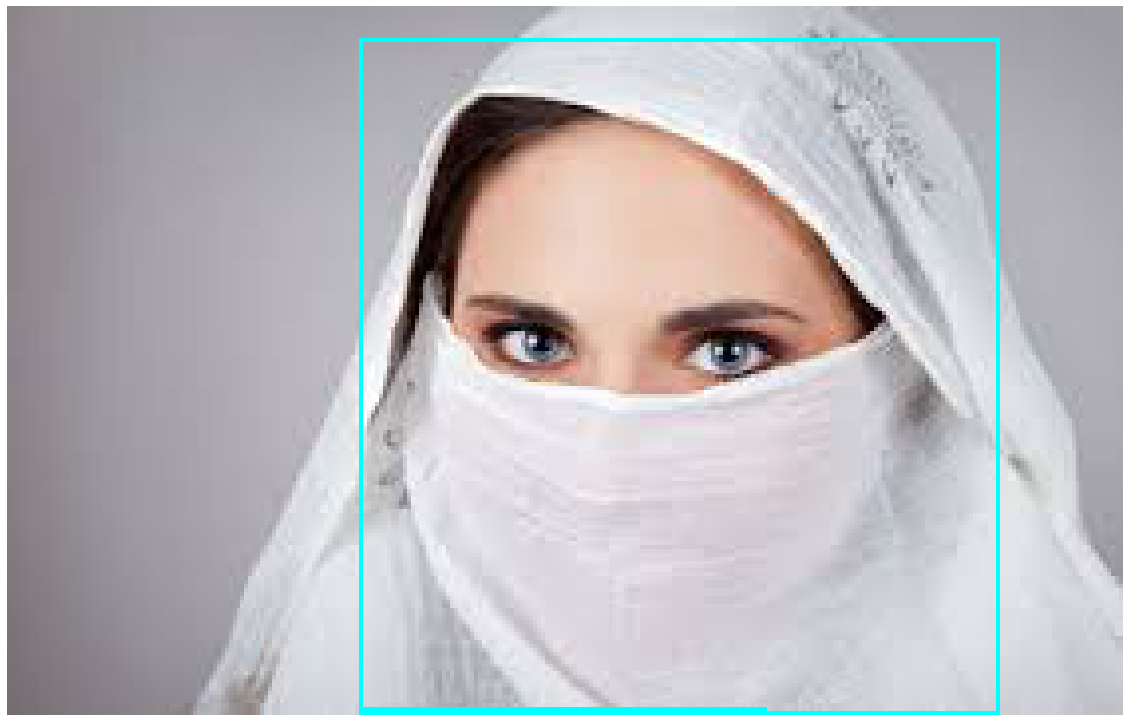

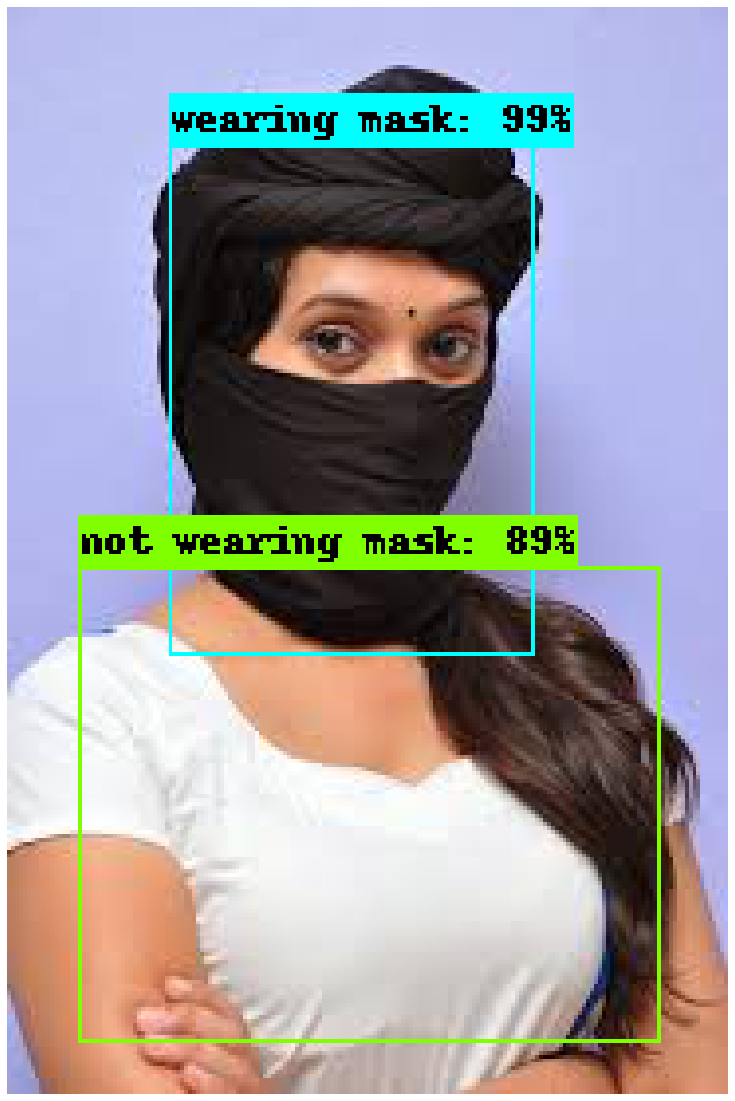

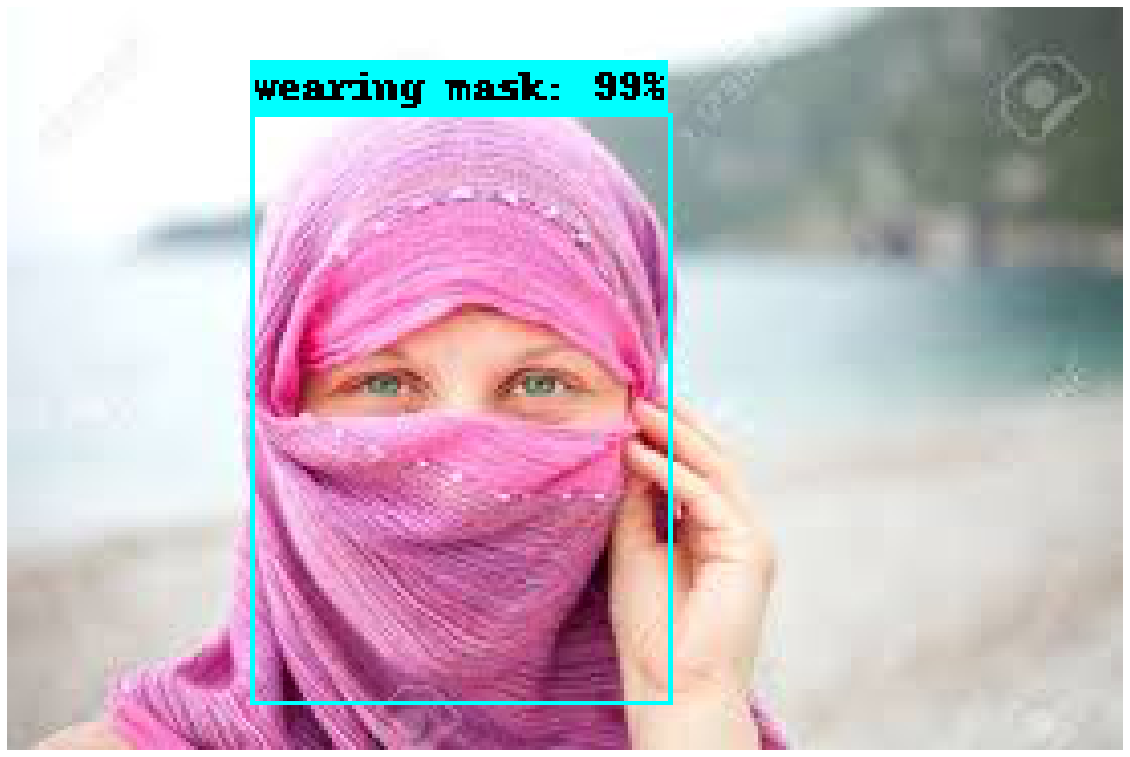

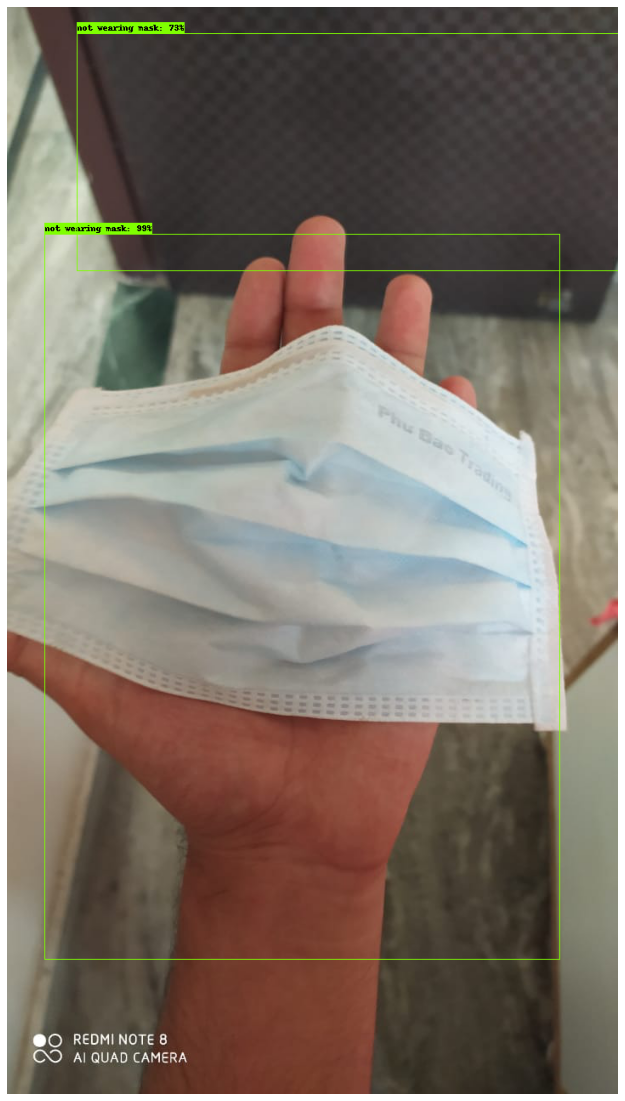

In [33]:
count=1
for image_path in path_test_image:
    image =Image.open(image_path)
    
    # the array based representation of the image will be used later in order to prepare
    # the reult image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    
    #Expand dimension since the model expects images to have same shape:[1,none, none, 3]
    
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    #actual detection
    output_dict = run_inference_for_single_image(image_np_expanded,detection_graph)
    
    #visualization of the the result of detection
    vis_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks = output_dict.get('detection_masks'),
        use_normalized_coordinates = True,
        line_thickness=1)
    
#     plt.figure(figsize=IMAGE_SIZE)
    
    plt.figure(figsize=(20,20))
#     plt.figure(figsize='IMAGE_SIZE')
    plt.axis('off')
    
    plt.imshow(image_np)
    plt.savefig(str(count)+'.jpg',)
    count+=1